# Data Processing

This notebook is for preparing the data for classical ML models

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import pyarrow
import sys


sys.path.append('../src')
from datasets import StateFarmDD

%matplotlib inline

In [2]:
# Loading in the data labels
train_labels = pd.read_csv('../data/training.csv')
train_labels.head()

,subject,classname,img
0,p016,c0,img_51066.jpg
1,p016,c0,img_19066.jpg
2,p016,c0,img_13965.jpg
3,p016,c0,img_12053.jpg
4,p016,c0,img_23592.jpg


In [3]:
# Getting the classnames
classnames = train_labels.classname.unique().tolist()
labels_to_names = {'c0': 'safe driving',"c1": 'texting - right', "c2": 'talking on the phone - right', 
                   "c3": 'texting - left', "c4": 'talking on the phone - left', "c5": 'operating the radio', 
                   "c6": 'drinking', "c7": 'reaching behind', "c8": 'hair and makeup', "c9": 'talking to passenger'}
classnames

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

(1, 100, 100)


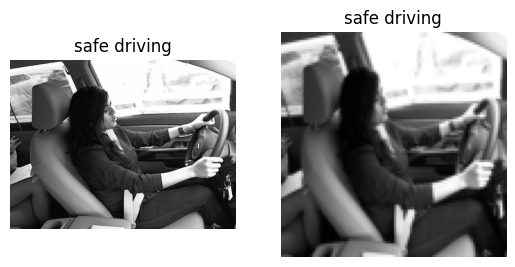

(1, 100, 100)


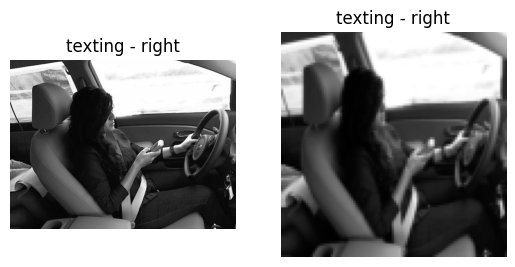

(1, 100, 100)


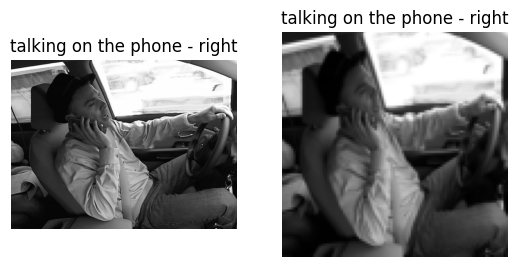

(1, 100, 100)


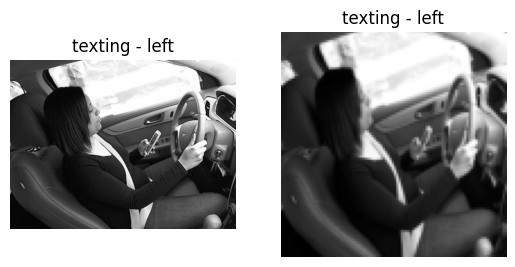

(1, 100, 100)


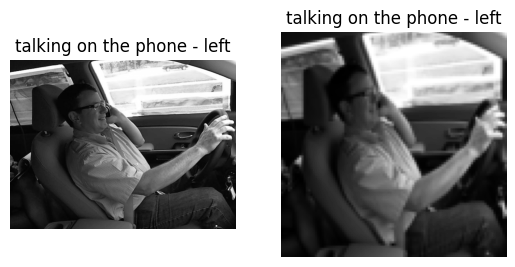

(1, 100, 100)


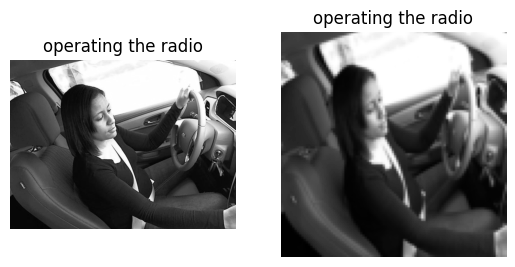

(1, 100, 100)


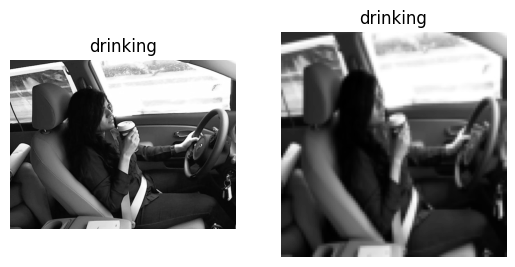

(1, 100, 100)


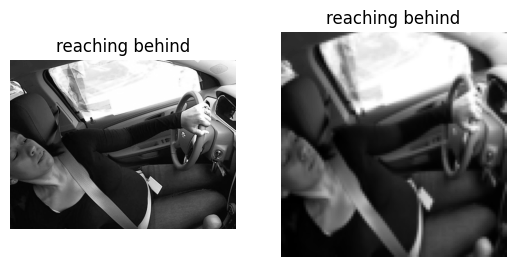

(1, 100, 100)


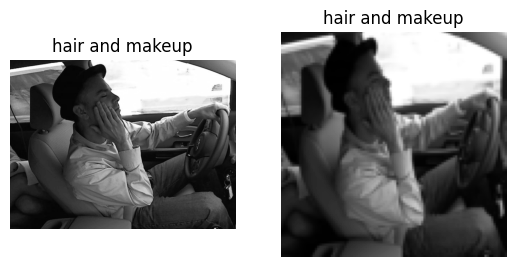

(1, 100, 100)


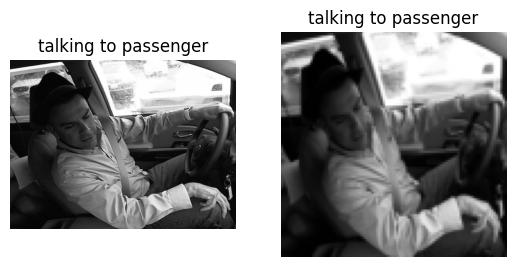

In [4]:
# Displaying a random image from each class
for classname in classnames:
    sample = train_labels[train_labels.classname == classname].sample(1)['img'].item()
    img = plt.imread(f'../data/imgs/train/{classname}/{sample}')
    # Converting image to grayscale
    img_tensor = torch.from_numpy(img.copy()).float()
    img_tensor = img_tensor.permute(2, 0, 1)
    grayscale_img = v2.Grayscale()(img_tensor).numpy()

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(grayscale_img.squeeze(0), cmap='gray')
    ax1.set_title(labels_to_names[classname])
    ax1.axis('off')

    # Plotting cropped image
    cropped_image = v2.Resize([100,100])(torch.from_numpy(grayscale_img).float()).numpy()
    print(cropped_image.shape)
    ax2.imshow(cropped_image.squeeze(0), cmap='gray')
    ax2.set_title(labels_to_names[classname])
    ax2.axis('off')
    plt.show()

In [5]:
# Building the Training Dataframe
transformation_pipeline = v2.Compose([
        v2.ToImage(),
        v2.Grayscale(),
        v2.Resize([100,100]),
        v2.ToDtype(torch.float32, scale=True),
])
training_dataset = StateFarmDD('../data/training.csv',transform_pipeline=transformation_pipeline)
training_dataloader = DataLoader(training_dataset, batch_size=len(training_dataset), shuffle=False)
x_train, y_train = next(iter(training_dataloader))
x_train = torch.flatten(x_train,start_dim=1).numpy()
y_train = y_train.numpy()

df = pd.DataFrame(x_train)
df['label'] = y_train
df.head()

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,label
0,0.105882,0.109804,0.133333,0.200000,0.141176,0.066667,0.035294,0.027451,0.054902,0.172549,...,0.039216,0.043137,0.050980,0.047059,0.047059,0.050980,0.050980,0.050980,0.054902,0
1,0.121569,0.125490,0.149020,0.223529,0.156863,0.070588,0.035294,0.027451,0.058824,0.196078,...,0.047059,0.050980,0.054902,0.054902,0.058824,0.054902,0.054902,0.050980,0.058824,0
2,0.125490,0.129412,0.149020,0.211765,0.160784,0.082353,0.043137,0.031373,0.050980,0.176471,...,0.050980,0.050980,0.050980,0.054902,0.054902,0.054902,0.058824,0.054902,0.054902,0
3,0.125490,0.137255,0.156863,0.231373,0.168627,0.078431,0.039216,0.027451,0.058824,0.200000,...,0.054902,0.058824,0.058824,0.062745,0.058824,0.058824,0.054902,0.058824,0.058824,0
4,0.141176,0.145098,0.160784,0.227451,0.172549,0.086275,0.043137,0.023529,0.054902,0.192157,...,0.050980,0.054902,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0


In [6]:
# Checking the shape
df.shape

(8015, 10001)

In [7]:
# Saving the dataframe in a parquet file
df.to_parquet('../data/train.parquet', engine='pyarrow',index=False)

In [8]:
validation_dataset = StateFarmDD('../data/validation.csv',transform_pipeline=transformation_pipeline)
validation_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False)
x_valid, y_valid = next(iter(validation_dataloader))
x_valid = torch.flatten(x_valid,start_dim=1).numpy()
y_valid = y_valid.numpy()

df = pd.DataFrame(x_valid)
df['label'] = y_valid
df.head()

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,label
0,0.109804,0.109804,0.117647,0.125490,0.133333,0.141176,0.145098,0.145098,0.145098,0.215686,...,0.043137,0.047059,0.043137,0.039216,0.035294,0.047059,0.066667,0.047059,0.074510,0
1,0.070588,0.074510,0.086275,0.101961,0.109804,0.113725,0.113725,0.117647,0.117647,0.192157,...,0.035294,0.035294,0.035294,0.035294,0.035294,0.039216,0.058824,0.039216,0.054902,0
2,0.062745,0.066667,0.066667,0.078431,0.090196,0.094118,0.098039,0.098039,0.098039,0.176471,...,0.035294,0.039216,0.039216,0.035294,0.031373,0.039216,0.050980,0.039216,0.058824,0
3,0.054902,0.054902,0.058824,0.062745,0.066667,0.070588,0.074510,0.074510,0.078431,0.160784,...,0.035294,0.031373,0.031373,0.031373,0.031373,0.035294,0.035294,0.043137,0.039216,0
4,0.054902,0.054902,0.058824,0.062745,0.066667,0.066667,0.070588,0.074510,0.078431,0.160784,...,0.031373,0.031373,0.035294,0.031373,0.031373,0.035294,0.043137,0.039216,0.039216,0


In [9]:
# Checking the shape
df.shape

(14409, 10001)

In [10]:
# Saving the dataframe in a parquet file
df.to_parquet('../data/valid.parquet', engine='pyarrow',index=False)